In [1]:
#Pytorch 神经网络
#torch.nn

import torch 
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):  #自定义模型，继承自nn.Module
    def __init__(self):
        super(Net, self).__init__()   #在模型初始化中调用父类初始化
        
        #定义模型结构 layer
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        #定义结构时需要考虑已经pooling对Feature map的维度影响
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def num_flat_feature(self,x):
        size = x.size()[1:]
        num_feature = 1
        for dim in size:
            num_feature *= dim
        return num_feature
        
        
    def forward(self, x):
        #定义前向传播
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.reshape(-1,self.num_flat_feature(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

#transforms.Compose([transform_list])可以将多个数据转换操作串联
#transforms.ToTensor()会将0-255的灰度图转化为0-1的tensor
#transforms.Normalize(mean_tuple, std_tuple) 进行 data = (data - mean) / std
#范围（0，1）经过变换会得到（-1，1）
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#num_workers表示使用多少个进程来导入数据， 0代表使用主进程， 2表示使用两个子进程
trainset = torchvision.datasets.CIFAR10(root='.\data',train=True, download=True, transform = transform)
trainloder = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='.\data',train=True, download=True, transform = transform)
testloder = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird','cat','dear', 'dog','frog', 'horse', 'ship', 'trunk')


Files already downloaded and verified
Files already downloaded and verified


In [3]:
net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

net.to(device)
lossFunc = torch.nn.CrossEntropyLoss()  #交叉熵损失
optimizer = optim.SGD(params=net.parameters(),lr = 0.001, momentum=0.9)  #SGD + momentum优化器



epoch = 5
print('start training...')
for e in range(epoch):
    running_loss = 0
    for i, data in enumerate(trainloder, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  #清空当前梯度
        output = net(inputs)   #获得一个batch的输出
        loss = lossFunc(output, labels)  #将predict的输出与labels进行损失计算
        loss.backward()  #损失反向传播获得参数梯度
        optimizer.step()  #优化器更新权重
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print('[%d, %5d] loss:%3f' % (e+1, i+1, running_loss / 2000))
        running_loss = 0
print('end training...')

cpu
start training...
[1,  2000] loss:0.001241
[1,  4000] loss:0.000784
[1,  6000] loss:0.000529
[1,  8000] loss:0.000957
[1, 10000] loss:0.000640
[1, 12000] loss:0.000419
[2,  2000] loss:0.000736
[2,  4000] loss:0.000644
[2,  6000] loss:0.000679
[2,  8000] loss:0.000674
[2, 10000] loss:0.000461
[2, 12000] loss:0.000434
[3,  2000] loss:0.000780
[3,  4000] loss:0.000573
[3,  6000] loss:0.001120
[3,  8000] loss:0.000587
[3, 10000] loss:0.000253
[3, 12000] loss:0.001557
[4,  2000] loss:0.000674
[4,  4000] loss:0.000361
[4,  6000] loss:0.000483
[4,  8000] loss:0.000434
[4, 10000] loss:0.000448
[4, 12000] loss:0.000204
[5,  2000] loss:0.000729
[5,  4000] loss:0.000344
[5,  6000] loss:0.000697
[5,  8000] loss:0.000659
[5, 10000] loss:0.000834
[5, 12000] loss:0.000602
end training...


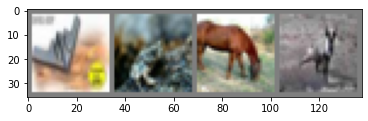

plane  frog horse  dear


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 +0.5 #(-1,1) => (0,1)
    arr = img.numpy()
    plt.imshow(np.transpose(arr, (1,2,0)))
    plt.show()
    
#输出测试数据中第一个batch的标签
test_dataiter = iter(testloder)
test_image, test_label = test_dataiter.next()
imshow(torchvision.utils.make_grid(test_image))
print(' '.join('%5s' % classes[test_label[j]] for j in range(4)))

In [5]:
#预测输出
predict_out = net(test_image)
_, predict_classes = torch.max(predict_out, 1)  #torch.max(tensor, axis)返回tensor在维度axis上的最大值v,及其index(v, index)
print(' '.join('%5s' % classes[predict_classes[j]] for j in range(4)))

trunk   cat horse  bird


In [6]:
#在测试集上测试性能
total = 0
correct = 0

with torch.no_grad():   #测试时在no_grad()状态下
    for data in testloder:
        images, labels = data
        out = net(images)
        _, predict = torch.max(out, 1)
        total += labels.size(0)
        correct += (labels == predict).sum().item()
        
print('Accuracy: %s' % (100*correct / total))

Accuracy: 65.584
